In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [2]:
from plotly import __version__
import cufflinks as cf

In [3]:
from plotly.offline import download_plotlyjs,init_notebook_mode,plot,iplot
init_notebook_mode(connected=True)
cf.go_offline()

In [4]:
%matplotlib inline

In [5]:
# Import dataset
# https://www.dataquest.io/blog/pandas-big-data/
df = pd.read_csv("RH_dataset_clean_w_censustracts.csv")

# Approach 1 to month, day, hour variables out of timestamp.
# Step1: convert pickup and dropoff timestamp from objects into 
# datetime format, making analysis of date and time easier.
df["Trip Start Timestamp"] = pd.to_datetime(df["Trip Start Timestamp"])
df["Trip End Timestamp"] = pd.to_datetime(df["Trip End Timestamp"])

# Filter dataset
list(df.columns)

['Unnamed: 0',
 'Trip ID',
 'Trip Start Timestamp',
 'Trip End Timestamp',
 'Trip Seconds',
 'Trip Miles',
 'Pickup Census Tract',
 'Dropoff Census Tract',
 'Trip Total',
 'Shared Trip Authorized',
 'Trips Pooled',
 'Pickup Centroid Latitude',
 'Pickup Centroid Longitude',
 'Pickup Centroid Location',
 'Dropoff Centroid Latitude',
 'Dropoff Centroid Longitude',
 'Dropoff Centroid Location',
 'Pickup_month',
 'Dropoff_month',
 'Pickup_day',
 'Dropoff_day',
 'Pickup_hour',
 'Dropoff_hour',
 'Pickup_day_of_week',
 'Dropoff_day_of_week',
 'Pickup_week_of_year',
 'Dropoff_week_of_year',
 'Average Speed',
 'Count']

In [6]:
df.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1142290 entries, 0 to 1142289
Data columns (total 29 columns):
 #   Column                      Non-Null Count    Dtype         
---  ------                      --------------    -----         
 0   Unnamed: 0                  1142290 non-null  int64         
 1   Trip ID                     1142290 non-null  object        
 2   Trip Start Timestamp        1142290 non-null  datetime64[ns]
 3   Trip End Timestamp          1142290 non-null  datetime64[ns]
 4   Trip Seconds                1140087 non-null  float64       
 5   Trip Miles                  1142244 non-null  float64       
 6   Pickup Census Tract         819473 non-null   float64       
 7   Dropoff Census Tract        814967 non-null   float64       
 8   Trip Total                  1142288 non-null  float64       
 9   Shared Trip Authorized      1142290 non-null  bool          
 10  Trips Pooled                1142290 non-null  int64         
 11  Pickup Centroid Latitude

# Optimize dtypes from float64 and int64 to float32 and int32

In [7]:
# First , change columns with dtype float64 to float32
df[["Trip Seconds", "Trip Miles", "Trip Total", "Pickup Centroid Latitude", 
    "Pickup Centroid Longitude", "Dropoff Centroid Latitude", 
    "Dropoff Centroid Longitude", "Average Speed", "Count"]] = df[["Trip Seconds", "Trip Miles", "Trip Total", 
                                                                   "Pickup Centroid Latitude", "Pickup Centroid Longitude", 
                                                                   "Dropoff Centroid Latitude", "Dropoff Centroid Longitude", "Average Speed", "Count"]].astype("float32")

# Second, change variables with dtype int64 to int32.
df[["Trips Pooled", "Pickup_month", "Dropoff_month",
      "Pickup_day", "Dropoff_day", "Pickup_hour", 
      "Dropoff_hour"]] = df[["Trips Pooled", "Pickup_month", "Dropoff_month",
                                        "Pickup_day", "Dropoff_day", "Pickup_hour", 
                                        "Dropoff_hour",]].astype("int32")


# Change dtype of "Pickup_day_of_week" and "Dropoff_day_of_week"
# and "Pickup_week_of_year" and "Dropoff_week_of_year"
# from int64 to int32.
df[["Pickup_day_of_week", "Dropoff_day_of_week",
    "Pickup_week_of_year", "Dropoff_week_of_year"]] = df[["Pickup_day_of_week", "Dropoff_day_of_week",
                                                            "Pickup_week_of_year", "Dropoff_week_of_year"]].astype("int32")


Time-based indexing is useful to select data using loc (row) function.
Partial string indexing more useful where you just pass part of timestamp.

Text(0, 0.5, 'Trips')

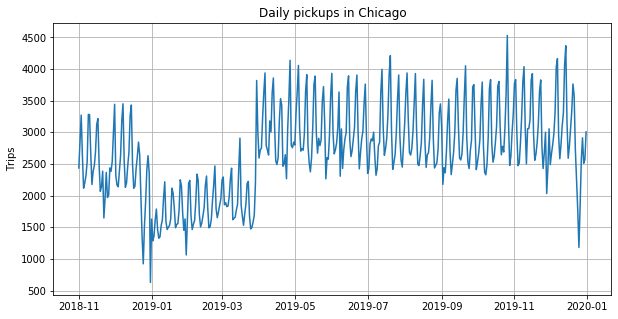

In [8]:
df.set_index("Trip Start Timestamp", inplace=True, drop=False)

# Resampling() splits DatetimeIndex into 15 min. time bins and groups by bin.
pickups_df = df[["Count"]]
pickups = pickups_df.Count.resample("15T").sum()
pickups15_df = pd.DataFrame(pickups)

# Plot daily rides using resample.
daily_pickups = df.Count.resample("d").sum()
daily_pickups_df = pd.DataFrame(daily_pickups)
daily_pickups_df

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(daily_pickups_df.index, daily_pickups_df["Count"])
ax.grid(True)
ax.set_title("Daily pickups in Chicago")
ax.set_ylabel("Trips")

# Time Series transformation for supervised learning

Restructure time series data set as supervised learning problem by using the value at previous step to predict value at next time-step.

Sliding window method or lagged method: use of prior steps to predict next time step. The number of previous steps is called the window width or size of the lag.

# Time Series prediction with classical methods

# 1st method: Seasonal ARIMA(X)

In [100]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse


In [72]:
def get_stationarity(timeseries):
    # rolling statistics
    rolling_mean = timeseries.rolling(window=7).mean()
    rolling_std = timeseries.rolling(window=7).std()
    
    # rolling statistics plot
    fig, ax = plt.subplots(figsize=(15,5))
    ax.plot(timeseries.index, timeseries, color="blue", label="Original")
    ax.plot(rolling_mean, color="red", label="Rolling Mean")
    ax.plot(rolling_std, color="black", label="Rolling Std")
    ax.legend(loc="best")
    ax.set_title("Rolling Mean & Standard Deviation")
    
    # Dickey-Fuller test:
    result = adfuller(timeseries["Count"])
    print("ADF Statistics: {}".format(result[0]))
    print("p-value: {}".format(result[1]))
    print("Critical Values:")
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

ADF Statistics: -1.6890226338928092
p-value: 0.4367770362704217
Critical Values:
	1%: -3.4465195891135845
	5%: -2.8686676281678634
	10%: -2.5705668101226085


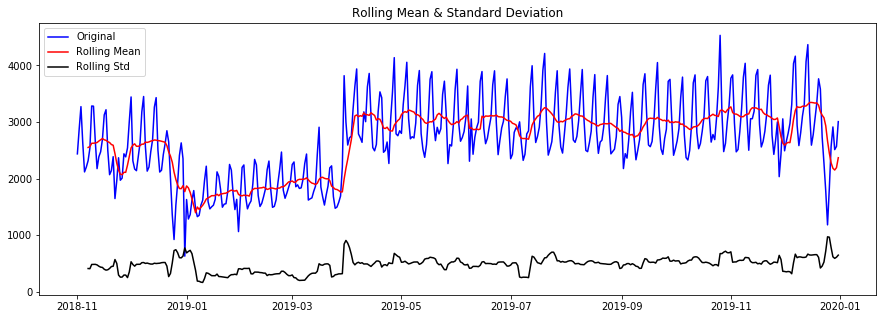

In [73]:
get_stationarity(daily_pickups_df)
# Rolling statistics: relatively constant with time, not conclusive.
# Augmented Dickey Fuller test: Time-series is stationary.

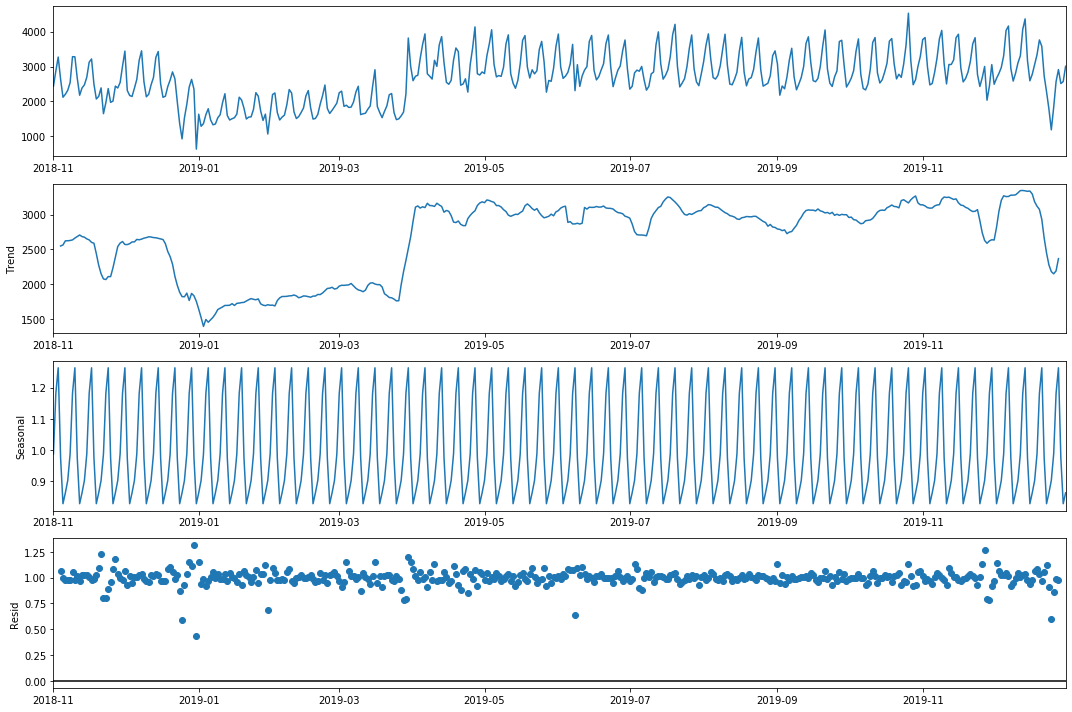

In [74]:
decomposition = seasonal_decompose(daily_pickups_df, model="multiplicative")
decomposition.plot()
plt.rcParams["figure.figsize"] = [15, 10]

In [90]:
# Use autoarima to find best (S)ARIMA(X) model with lowest AIC value
stepwise_model = auto_arima(daily_pickups_df, m=7, 
                            start_p=0, max_d=2, start_q=0,
                            max_p=3, max_q=3, start_P=0,
                            start_Q=0, max_D=2, max_P=3, 
                            max_Q=3, trace=True, seasonal=True, 
                            error_action="ignore", suppress_warnings=True, stepwise=True)

            
# print(stepwise_model)
# Best SARIMAX(1, 1, 0)x(1, 0, [1], 7)

Performing stepwise search to minimize aic
Fit ARIMA(0,1,0)x(0,0,0,7) [intercept=True]; AIC=6460.766, BIC=6468.870, Time=0.021 seconds
Fit ARIMA(1,1,0)x(1,0,0,7) [intercept=True]; AIC=6151.463, BIC=6167.671, Time=0.451 seconds
Fit ARIMA(0,1,1)x(0,0,1,7) [intercept=True]; AIC=6320.977, BIC=6337.185, Time=0.290 seconds
Fit ARIMA(0,1,0)x(0,0,0,7) [intercept=False]; AIC=6458.771, BIC=6462.823, Time=0.013 seconds
Fit ARIMA(1,1,0)x(0,0,0,7) [intercept=True]; AIC=6453.682, BIC=6465.838, Time=0.030 seconds
Fit ARIMA(1,1,0)x(2,0,0,7) [intercept=True]; AIC=6058.734, BIC=6078.994, Time=0.810 seconds
Fit ARIMA(1,1,0)x(3,0,0,7) [intercept=True]; AIC=6031.257, BIC=6055.570, Time=1.326 seconds
Near non-invertible roots for order (1, 1, 0)(3, 0, 0, 7); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.992)
Fit ARIMA(1,1,0)x(2,0,1,7) [intercept=True]; AIC=5967.018, BIC=5991.330, Time=1.464 seconds
Near non-invertible roots for order (1, 1, 0)(2, 0, 1, 7); set

In [91]:
stepwise_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  426
Model:             SARIMAX(1, 1, 0)x(1, 0, [1], 7)   Log Likelihood               -2975.378
Date:                             Sat, 23 May 2020   AIC                           5960.756
Time:                                     21:18:36   BIC                           5981.016
Sample:                                          0   HQIC                          5968.760
                                             - 426                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0414      0.155      0.267      0.789      -0.262       0.345
ar.L1         -0.2526      0.028     -8.911      0.000      -0.308      -0.197
ar.S.L7        0.9991      0.001    848.332      0.000       0.997       1.001
ma.S.L7       -0.9337      0.031    -30.002      0.000      -0.995      -0.873
sigma2       6.77e+04   2819.964     24.009      0.000    6.22e+04    7.32e+04
===================================================================================
Ljung-Box (Q):                       38.27   Jarque-Bera (JB):              1154.85
Prob(Q):                              0.55   Prob(JB):                         0.00
Heteroskedasticity (H):               1.00   Skew:                            -0.54
Prob(H) (two-sided):                  1.00   Kurtosis:                        11.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Split data into train and test: train on first 10 months, test on last 4 months

In [92]:
# Break data into train and test data
train = daily_pickups_df.loc["2018-11-01":"2019-07-31"]
test = daily_pickups_df.loc["2019-08-01":]
test

,Count
Trip Start Timestamp,
2019-08-01,3133.0
2019-08-02,3611.0
2019-08-03,3937.0
2019-08-04,3216.0
2019-08-05,2682.0
...,...
2019-12-27,2567.0
2019-12-28,2912.0
2019-12-29,2511.0


Training the model

In [93]:
stepwise_model.fit(train)

ARIMA(order=(1, 1, 0), seasonal_order=(1, 0, 1, 7), suppress_warnings=True)

Model Evaluation: obtaining prediction values (n=143) for test data and plot performance with error metric

In [99]:
future_forecast = stepwise_model.predict(len(test))

# Create dataframe for predictions and concatenate with original data
future_forecast = pd.DataFrame(future_forecast, 
                               index=test.index,
                               columns=["Prediction"])

daily_pickups_testpredictions = pd.concat([daily_pickups_df, future_forecast], axis=1)
testdata_predictions = pd.concat([test,future_forecast], axis=1)

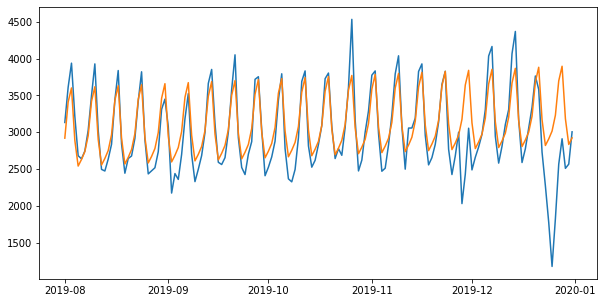

In [95]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(testdata_predictions["Count"])
ax.plot(testdata_predictions["Prediction"])

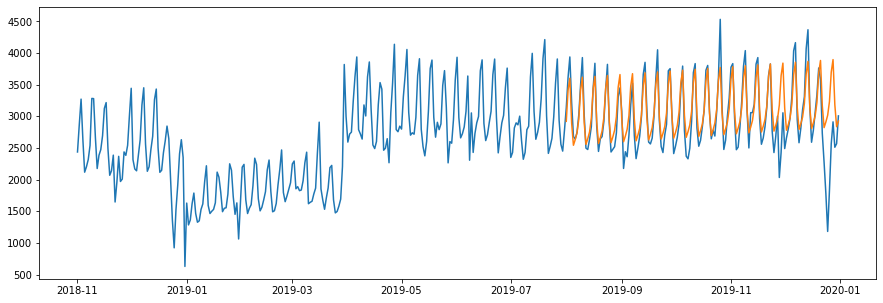

In [96]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(daily_pickups_testpredictions["Count"])
ax.plot(daily_pickups_testpredictions["Prediction"])

In [127]:
def eval_metrics(testdata):
    arima_rmse_error = rmse(testdata["Count"], testdata["Prediction"])
    arima_mse_error = arima_rmse_error**2
    mean_value = daily_pickups_df["Count"].mean()
    
    print(f'MSE Error: {arima_mse_error}\nRMSE Error: {arima_rmse_error}\nMean: {mean_value}')

In [128]:
eval_metrics(testdata_predictions)

MSE Error: 126054.91383787313
RMSE Error: 355.042129666147
Mean: 2681.431884765625


# 2nd method: Holt-Winters Exponential Smoothing

In [104]:
from statsmodels.tsa.api import ExponentialSmoothing as es
from statsmodels.tsa.api import SimpleExpSmoothing as ses
from statsmodels.tsa.api import Holt as holt


In [182]:
# Holt-Winters Exponential Smoothing
model = es(train, trend="add", seasonal="add", seasonal_periods=7, damped=True)
fit = model.fit()
predictions = fit.forecast(len(test))

In [183]:
# Concatenate predictions on test data with test data set and daily pickups
HW_testpredictions = pd.DataFrame(predictions)
HW_testpredictions.rename(columns={0: "Prediction"}, inplace=True)
HW_testdata_predictions = pd.concat([test, HW_testpredictions], axis=1)
HW_daily_pickups_testpredictions = pd.concat([daily_pickups_df, HW_testpredictions], axis=1)

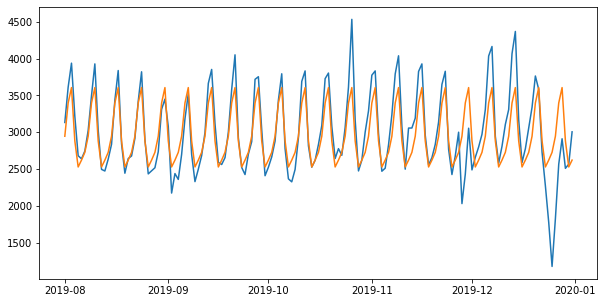

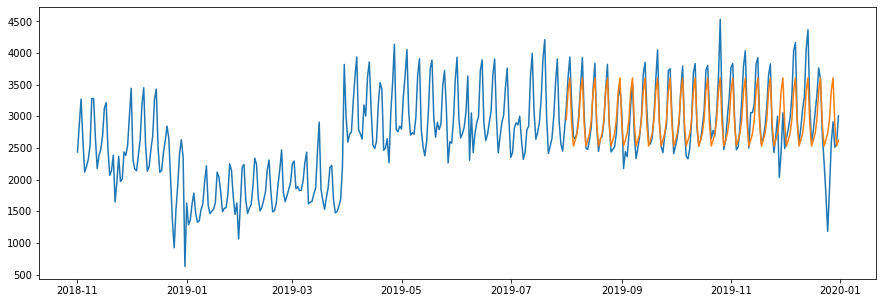

In [184]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(HW_testdata_predictions["Count"])
ax.plot(HW_testdata_predictions["Prediction"])

fig, ax = plt.subplots(figsize=(15,5))
ax.plot(HW_daily_pickups_testpredictions["Count"])
ax.plot(HW_daily_pickups_testpredictions["Prediction"])


In [185]:
eval_metrics(HW_testdata_predictions)

MSE Error: 106599.0909198731
RMSE Error: 326.4951621691707
Mean: 2681.431884765625
